In [7]:
import psycopg2
import pandas as pd
from datetime import datetime, timedelta

exposures = psycopg2.connect('service=exposure')
department_id = 78503
start_date = (datetime.utcnow() - timedelta(days=30))

def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

In [8]:
incidents = pd.read_sql_query(f'SELECT _id, incident_number, created_at FROM "Incidents" WHERE department_id = {department_id} AND created_at > \'{start_date}\'', exposures)
incidents = incidents.set_index('_id')
incidents.drop_duplicates(subset ='incident_number', 
                     keep = False, inplace = True) 

incidents = incidents.created_at.dt.floor('d')\
       .value_counts().to_frame()
incidents.rename(columns={'created_at': 'incidents'}, inplace=True)
incidents.sort_index(inplace=True)
incidents

,incidents
2020-06-13 00:00:00+00:00,170
2020-06-14 00:00:00+00:00,97
2020-06-16 00:00:00+00:00,131
2020-06-17 00:00:00+00:00,2259
2020-06-18 00:00:00+00:00,229
2020-06-19 00:00:00+00:00,396
2020-06-20 00:00:00+00:00,309
2020-06-21 00:00:00+00:00,384
2020-06-22 00:00:00+00:00,249
2020-06-23 00:00:00+00:00,281


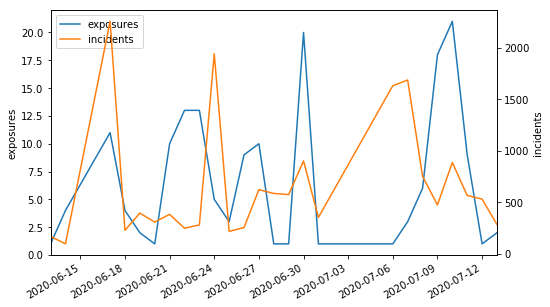

In [13]:
exposures_df = pd.read_sql_query(f'SELECT created_at, "exposureType" FROM "Exposures" WHERE department_id = {department_id} AND created_at > \'{start_date}\'', exposures)
exposures_df.created_at = pd.to_datetime(exposures_df.created_at)
exposures_df.set_index('created_at')
exposures_count_df = exposures_df.created_at.dt.floor('d')\
       .value_counts().to_frame()
exposures_count_df.sort_index(inplace=True)
exposures_count_df.rename(columns={'created_at':'exposures'}, inplace=True)

exposures_incidents=pd.merge(exposures_count_df,incidents, how='inner', left_index=True, right_index=True)
exposures_incidents

plot_multi(exposures_incidents, figsize=(8, 5))

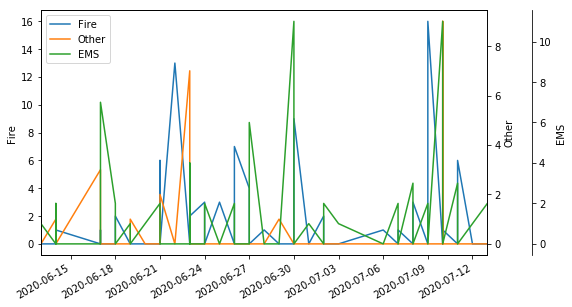

In [50]:
exposure_types = exposures_df.exposureType.unique()

type_counts = [
    exposures_df[exposures_df['exposureType'] == type].created_at.dt.floor('d')
    .value_counts().to_frame().rename(columns={'created_at': type}) 
    for type in exposure_types
]
#type_counts += [incidents]
type_counts_df = pd.concat(type_counts, sort=False)

type_counts_df.fillna(0, inplace=True)
type_counts_df
plot_multi(type_counts_df, figsize=(8, 5))

In [39]:
exposures_df

,created_at,exposureType
0,2020-06-21 00:57:49.829474+00:00,Fire
1,2020-06-17 07:53:58.907850+00:00,Other
2,2020-06-17 23:15:00.213080+00:00,EMS
3,2020-06-18 06:10:38.955795+00:00,Fire
4,2020-06-20 19:43:46.658213+00:00,EMS
...,...,...
170,2020-07-11 20:09:22.761431+00:00,Fire
171,2020-07-11 20:11:23.561719+00:00,Fire
172,2020-07-12 02:37:31.899994+00:00,EMS
173,2020-07-13 14:14:30.247613+00:00,EMS
